In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import h5py
from tqdm import tqdm
from torch.amp import GradScaler, autocast

In [3]:
# -------------------------
# Squeeze-and-Excitation Block
# -------------------------
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, channels // reduction, 1),
            nn.GELU(),
            nn.Conv2d(channels // reduction, channels, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return x * self.fc(x)

# -------------------------
# Attention Gate for Skip Connections
# -------------------------
class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super().__init__()
        self.W_g = nn.Conv2d(F_g, F_int, kernel_size=1)
        self.W_x = nn.Conv2d(F_l, F_int, kernel_size=1)
        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1),
            nn.Sigmoid()
        )
        self.relu = nn.ReLU(inplace=True)
    def forward(self, g, x):
        # g: gating signal, x: skip connection
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)
        return x * psi

# -------------------------
# Depthwise Separable Conv (for ASPP)
# -------------------------
class SepConv(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, padding, dilation=1):
        super().__init__()
        self.depthwise = nn.Conv2d(in_ch, in_ch, kernel_size, padding=padding,
                                   dilation=dilation, groups=in_ch)
        self.pointwise = nn.Conv2d(in_ch, out_ch, 1)
        self.norm = nn.BatchNorm2d(out_ch)
        self.act = nn.ReLU()
    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return self.act(self.norm(x))

# -------------------------
# ASPP Module with Mixed Kernels
# -------------------------
class ASPP(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        dilations = [1,6,12,18]
        kernels   = [3,3,5,7]
        self.branches = nn.ModuleList()
        for d,k in zip(dilations,kernels):
            pad = (k//2)*d
            self.branches.append(SepConv(in_ch, out_ch, kernel_size=k, padding=pad, dilation=d))
        self.merge = nn.Sequential(
            nn.Conv2d(len(dilations)*out_ch, out_ch, 1),
            nn.BatchNorm2d(out_ch), nn.ReLU(),
        )
    def forward(self,x):
        return self.merge(torch.cat([b(x) for b in self.branches], dim=1))

class BottleneckTransformer(nn.Module):
    def __init__(self, dim, heads=8, depth=6, mlp_dim=None):
        super().__init__()
        mlp_dim = mlp_dim or dim*4
        layer = nn.TransformerEncoderLayer(d_model=dim, nhead=heads,
                                           dim_feedforward=mlp_dim,
                                           activation='relu', norm_first=True)
        self.encoder = nn.TransformerEncoder(layer, depth)
        self.norm    = nn.LayerNorm(dim)
    def forward(self,x):
        bs,c,h,w = x.shape
        x = x.flatten(2).permute(2,0,1)
        x = self.encoder(x)
        x = x.permute(1,2,0).view(bs,c,h,w)
        return self.norm(x.permute(0,2,3,1)).permute(0,3,1,2)

class DoubleConv(nn.Module):
    """
    A sequence of two 3x3 convolutions each followed by ReLU activation.
    """
    def __init__(self, in_channels, out_channels, activation):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=True),
            #nn.BatchNorm2d(out_channels),
            activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            activation
        )

    def forward(self, x):
        return self.double_conv(x)

# -------------------------
# Encoder/Decoder Blocks
# -------------------------
class EncoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch, activation, pool=True):
        super().__init__()
        #self.conv = DoubleConv(in_ch, out_ch, activation)
        self.conv = ASPP(in_ch, out_ch)
        self.pool = pool
    def forward(self,x):
        x = self.conv(x)
        skip = x
        x = F.max_pool2d(x, kernel_size=3, stride=2, padding=1) if self.pool else x
        return x, skip

class DecoderBlock(nn.Module):
    def __init__(self,in_ch,out_ch, activation, attn=True):
        super().__init__()
        self.up   = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)
        self.attn = attn
        if attn:
            self.attn = AttentionGate(F_g=out_ch, F_l=out_ch, F_int=out_ch//2)
            #self.conv = DoubleConv(out_ch*2, out_ch, activation)
            self.conv = ASPP(out_ch*2, out_ch)
        else:
            #self.conv = DoubleConv(out_ch, out_ch, activation)
            self.conv = ASPP(out_ch, out_ch)
    def forward(self,x,skip):
        x = self.up(x)
        if self.attn:
            skip = self.attn(g=x, x=skip)
            x = self.conv(torch.cat([x,skip],dim=1))
        else:
            x = self.conv(x)
        return x

class UNetEnhanced(nn.Module):
    """
    A basic U-Net architecture without attention, SE blocks, or deep supervision.
    """
    def __init__(self, downfeatures=None, downactivation=None, bottleneckfeatures=None, upfeatures=None, upactivation=None):
        super(UNetEnhanced, self).__init__()
        in_channels = 1
        out_channels = 1
        if downfeatures is None:
            downfeatures = [128, 256, 512, 1024]
        if bottleneckfeatures is None:
            bottleneckfeatures = downfeatures[-1] * 2
        if upfeatures is None:
            upfeatures = downfeatures[::-1]
        if downactivation is None:
            downactivation = [nn.ReLU(inplace=True) for _ in range(len(downfeatures))]
        else:
            downactivation = [get_activation(act) for act in downactivation]
        if upactivation is None:
            upactivation = downactivation[::-1]
        else:
            upactivation = [get_activation(act) for act in upactivation]

        # Encoder path
        self.downs = nn.ModuleList()
        for l, feature in enumerate(downfeatures):
            self.downs.append(EncoderBlock(in_channels, feature, downactivation[l]))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(downfeatures[-1], bottleneckfeatures, nn.ReLU(inplace=True))

        # Decoder path
        self.ups = nn.ModuleList()
        in_channels = bottleneckfeatures
        for l, feature in enumerate(upfeatures):
            self.ups.append(DecoderBlock(in_channels, feature, upactivation[l], attn=False if l==0 else True))
            in_channels = feature

        # Final 1x1 conv
        self.final_conv = nn.Conv2d(upfeatures[-1], out_channels, kernel_size=1)

    def forward(self, x):
        x = nn.LayerNorm(normalized_shape=x.shape[1:], elementwise_affine=False)(x)
        skip_connections = []

        # Downsampling
        for down in self.downs:
            x, skip = down(x)
            skip_connections.append(skip)

        # Bottleneck
        x = self.bottleneck(x)

        # Reverse skip connections for decoding
        skip_connections = skip_connections[::-1]
        for i, up in enumerate(self.ups):
            if i == 0:
                x = up(x, None)
            else:
                # Use attention gate for all but the first decoder block
                #print ("X:", x.mean(), x.std(), "SKIP:", skip_connections[i].mean(), skip_connections[i].std())
                x = up(x, skip_connections[i])
        #LayerNorm
        x = nn.LayerNorm(normalized_shape=x.shape[1:], elementwise_affine=False)(x)
        x = self.final_conv(x)
        return x


In [4]:
class H5Dataset(Dataset):
    def __init__(self,path): self.path=path; self.f=None
    def __len__(self): return h5py.File(self.path,'r')['x'].shape[0]
    def __getitem__(self,idx):
        if self.f is None:
            self.f = h5py.File(self.path,'r', swmr=True)
        x = torch.from_numpy(self.f['x'][idx]).float()
        y = torch.from_numpy(self.f['y'][idx]).float()
        return x, y

def get_activation(name):
    """
    Get activation function by name.
    """
    activations = {
        'relu': nn.ReLU(inplace=True),
        'leaky_relu': nn.LeakyReLU(inplace=True),
        'elu': nn.ELU(inplace=True),
        'prelu': nn.PReLU(),
        'sigmoid': nn.Sigmoid(),
        'tanh': nn.Tanh(),
        'softmax': nn.Softmax(dim=1),
    }
    return activations.get(name, None)

def train(model, train_ds, val_ds, loss=None, epochs=100, help_factor=1):
    bs, max_batches = 64, 500
     # ─── train loader ───
    # pick exactly bs*max_batches random samples from train set
    tr_idx = torch.randperm(len(train_ds))[: bs * max_batches]
    output_size = get_model_output_size(model)


    tr_loader = DataLoader(
        train_ds,
        batch_size=bs,
        sampler=SubsetRandomSampler(tr_idx),
        num_workers=10,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=8,
    )

    # ─── val loader ───
    # just iterate through val.h5 in order (or set shuffle=True if you like)
    val_loader = DataLoader(
        val_ds,
        batch_size=bs,
        shuffle=False,
        num_workers=10,
        pin_memory=True,
        persistent_workers=True,
        prefetch_factor=8,
    )
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    if loss is None:
        crit  = ComboLoss(pos_weight=500, bce_weight=0.5, dice_weight=0.5)
    else:
        crit = loss

    opt   = torch.optim.Adam(model.parameters(), lr=1e-4)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr=1e-4, steps_per_epoch=len(tr_loader), epochs=epochs)

    scaler = GradScaler('cuda' if torch.cuda.is_available() else 'cpu')
    train_losses = []
    val_losses = []
    val_f1s = []
    val_precisions = []
    val_recalls = []

    for epoch in range(1, epochs+1):
        # ——— train ———
        model.train()
        total_loss = 0.0
        for batch_num, (imgs, msk) in enumerate(pbar:=tqdm(tr_loader, desc=f"Epoch {epoch}")):
            imgs[msk==1] *= help_factor
            imgs = imgs/50
            imgs = imgs.to(device)
            msk = downsize_y(msk, output_size)
            msk  = msk.to(device)
            opt.zero_grad()
            with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                seg_logits = model(imgs)
                loss = crit(seg_logits, msk)
            scaler.scale(loss).backward()
            scaler.unscale_(opt)
            scaler.step(opt)
            scaler.update()
            total_loss += loss.item()
            pbar.set_postfix(avg_train_loss=total_loss/(bs*(batch_num+1)), batch_loss=loss.item()/bs, lr=sched.get_last_lr()[0])
            sched.step()
        train_losses.append(total_loss/len(train_ds))

        # ——— validate ———
        model.eval()
        with torch.no_grad():
            tp=fp=fn=0
            loss = 0
            for imgs, msk in val_loader:
                imgs[msk==1] *= help_factor
                imgs = imgs/50
                imgs = imgs.to(device)
                msk = downsize_y(msk, output_size)
                msk  = msk.to(device)
                with autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                    seg_logits = model(imgs)
                    loss += crit(seg_logits, msk)
                preds = (torch.sigmoid(seg_logits)>0.5).float().view(-1)
                t     = msk.view(-1)

                tp += (preds * t).sum().item()
                fp += (preds * (1-t)).sum().item()
                fn += ((1-preds)*t).sum().item()

            prec = tp/(tp+fp+1e-8)
            rec  = tp/(tp+fn+1e-8)
            f1   = 2*prec*rec/(prec+rec+1e-8)
            val_losses.append(loss/len(val_ds))
            val_f1s.append(f1)
            val_precisions.append(prec)
            val_recalls.append(rec)
            print(f"Val loss: {loss/len(val_ds):.4f}  Val F1: {f1:.4f}  (P={prec:.4f}, R={rec:.4f})")

def downsize_y(y, size):
    """
    Downsize the y tensor to the given size.
    """
    if y.shape[-2:] == size:
        return y
    else:
        #downsized = F.interpolate(y, size=size, mode='bilinear', align_corners=True)
        downsized = F.interpolate(y, size=size, mode="area")
        # make downsized tensor only 0 or 1 by doing ceil
        downsized = torch.ceil(downsized)
        return downsized

def get_model_output_size(model):
    """
    Get the output size of the model.
    """
    x = torch.randn(1, 1, 128, 128)
    x = x.to('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        y = model(x)
    return y.shape[2:]

In [5]:
class FocalTverskyLoss(nn.Module):
    def __init__(self, alpha=0.9, beta=0.1, gamma=2.0, eps=1e-6):
        super().__init__()
        self.alpha, self.beta, self.gamma, self.eps = alpha, beta, gamma, eps
    def forward(self, preds, targets):
        preds = preds.view(-1)
        targets = targets.view(-1)
        TP = (preds * targets).sum()
        FP = (preds * (1 - targets)).sum()
        FN = ((1 - preds) * targets).sum()
        tversky = (TP + self.eps) / (TP + self.alpha*FN + self.beta*FP + self.eps)
        return torch.pow((1 - tversky), self.gamma)

class ComboLoss(nn.Module):
    def __init__(self, pos_weight=500.0, bce_weight=0.2, dice_weight=0.4):
        super().__init__()
        self.bce  = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))
        self.ft   = FocalTverskyLoss(alpha=0.8, beta=0.2, gamma=0.9)
        self.bw, self.dw= bce_weight, dice_weight
    def forward(self, logits, targets):
        bce_loss  = self.bce(logits, targets)
        dice_loss = self.ft(torch.sigmoid(logits), targets)
        return self.bw*bce_loss + self.dw*dice_loss

In [6]:
down_filters = [64,  128, 256, 512, 1024]
up_filters   = [1024, 512,]
down_activations = ['relu', 'relu', 'relu', 'relu', 'relu', 'relu']
up_activations = ['relu', 'relu', 'relu', 'relu']
model = UNetEnhanced(downfeatures= down_filters, upfeatures=up_filters, downactivation=down_activations, upactivation=up_activations)
get_model_output_size(model)
loss = ComboLoss(pos_weight=100, bce_weight=0, dice_weight=1)
train_ds = H5Dataset('train.h5')
val_ds   = H5Dataset('val.h5')
train(model, train_ds, val_ds, loss=loss, epochs=4, help_factor=100)
train(model, train_ds, val_ds, loss=loss, epochs=8, help_factor=10)
train(model, train_ds, val_ds, loss=loss, epochs=16, help_factor=2)
train(model, train_ds, val_ds, loss=loss, epochs=32, help_factor=1.5)
train(model, train_ds, val_ds, loss=loss, epochs=90, help_factor=1)

Epoch 1: 100%|██████████| 235/235 [00:27<00:00,  8.40it/s, avg_train_loss=0.00681, batch_loss=0.0018, lr=9.35e-5] 


Val loss: 0.0062  Val F1: 0.8783  (P=0.8083, R=0.9616)


Epoch 2: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.00131, batch_loss=0.00113, lr=8.12e-5] 


Val loss: 0.0049  Val F1: 0.8867  (P=0.8165, R=0.9703)


Epoch 3: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.000928, batch_loss=0.000674, lr=2.83e-5]


Val loss: 0.0044  Val F1: 0.9311  (P=0.8876, R=0.9789)


Epoch 4: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.000714, batch_loss=0.000306, lr=4e-10]  


Val loss: 0.0043  Val F1: 0.9378  (P=0.8980, R=0.9814)


Epoch 1: 100%|██████████| 235/235 [00:27<00:00,  8.53it/s, avg_train_loss=0.000921, batch_loss=0.000574, lr=3.94e-5]


Val loss: 0.0047  Val F1: 0.9112  (P=0.8570, R=0.9727)


Epoch 2: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.000957, batch_loss=0.000721, lr=9.35e-5]


Val loss: 0.0048  Val F1: 0.8492  (P=0.7449, R=0.9876)


Epoch 3: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.00101, batch_loss=0.000958, lr=9.72e-5] 


Val loss: 0.0047  Val F1: 0.8916  (P=0.8339, R=0.9579)


Epoch 4: 100%|██████████| 235/235 [00:27<00:00,  8.54it/s, avg_train_loss=0.000957, batch_loss=0.000303, lr=8.12e-5]


Val loss: 0.0042  Val F1: 0.9322  (P=0.8888, R=0.9802)


Epoch 5: 100%|██████████| 235/235 [00:28<00:00,  8.35it/s, avg_train_loss=0.000849, batch_loss=0.00138, lr=5.56e-5] 


Val loss: 0.0043  Val F1: 0.9200  (P=0.8698, R=0.9765)


Epoch 6: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.00076, batch_loss=0.000469, lr=2.83e-5] 


Val loss: 0.0043  Val F1: 0.9303  (P=0.8884, R=0.9765)


Epoch 7: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.000687, batch_loss=0.000891, lr=7.66e-6]


Val loss: 0.0042  Val F1: 0.9341  (P=0.8891, R=0.9839)


Epoch 8: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.000639, batch_loss=0.00104, lr=4e-10]   


Val loss: 0.0042  Val F1: 0.9386  (P=0.9046, R=0.9752)


Epoch 1: 100%|██████████| 235/235 [00:27<00:00,  8.56it/s, avg_train_loss=0.00716, batch_loss=0.00576, lr=1.39e-5]


Val loss: 0.0129  Val F1: 0.1201  (P=0.0660, R=0.6716)


Epoch 2: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.00541, batch_loss=0.00521, lr=3.95e-5]


Val loss: 0.0114  Val F1: 0.2149  (P=0.1254, R=0.7509)


Epoch 3: 100%|██████████| 235/235 [00:27<00:00,  8.56it/s, avg_train_loss=0.00452, batch_loss=0.00533, lr=7.03e-5]


Val loss: 0.0108  Val F1: 0.2503  (P=0.1480, R=0.8104)


Epoch 4: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s, avg_train_loss=0.00403, batch_loss=0.00375, lr=9.36e-5]


Val loss: 0.0093  Val F1: 0.4111  (P=0.2787, R=0.7831)


Epoch 5: 100%|██████████| 235/235 [00:27<00:00,  8.55it/s, avg_train_loss=0.00365, batch_loss=0.00665, lr=9.99e-5]


Val loss: 0.0109  Val F1: 0.2288  (P=0.1321, R=0.8550)


Epoch 6: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00342, batch_loss=0.00192, lr=9.72e-5]


Val loss: 0.0105  Val F1: 0.2710  (P=0.1618, R=0.8327)


Epoch 7: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.00319, batch_loss=0.00253, lr=9.08e-5]


Val loss: 0.0090  Val F1: 0.4198  (P=0.2786, R=0.8513)


Epoch 8: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.0029, batch_loss=0.00247, lr=8.12e-5] 


Val loss: 0.0092  Val F1: 0.3876  (P=0.2506, R=0.8550)


Epoch 9: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.00276, batch_loss=0.00214, lr=6.91e-5]


Val loss: 0.0088  Val F1: 0.4421  (P=0.3013, R=0.8302)


Epoch 10: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.00258, batch_loss=0.00211, lr=5.56e-5]


Val loss: 0.0086  Val F1: 0.4459  (P=0.3006, R=0.8637)


Epoch 11: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00242, batch_loss=0.00252, lr=4.16e-5]


Val loss: 0.0084  Val F1: 0.4884  (P=0.3428, R=0.8488)


Epoch 12: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.00229, batch_loss=0.00388, lr=2.83e-5]


Val loss: 0.0081  Val F1: 0.5551  (P=0.4179, R=0.8265)


Epoch 13: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.00216, batch_loss=0.00181, lr=1.67e-5]


Val loss: 0.0087  Val F1: 0.4554  (P=0.3100, R=0.8575)


Epoch 14: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.00203, batch_loss=0.00272, lr=7.66e-6]


Val loss: 0.0086  Val F1: 0.4747  (P=0.3303, R=0.8439)


Epoch 15: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00198, batch_loss=0.00303, lr=1.95e-6] 


Val loss: 0.0083  Val F1: 0.5178  (P=0.3747, R=0.8377)


Epoch 16: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.00194, batch_loss=0.00262, lr=4e-10]    


Val loss: 0.0084  Val F1: 0.5064  (P=0.3631, R=0.8364)


Epoch 1: 100%|██████████| 235/235 [00:27<00:00,  8.55it/s, avg_train_loss=0.00756, batch_loss=0.00658, lr=6.53e-6]


Val loss: 0.0140  Val F1: 0.0650  (P=0.0344, R=0.5836)


Epoch 2: 100%|██████████| 235/235 [00:28<00:00,  8.31it/s, avg_train_loss=0.00721, batch_loss=0.00894, lr=1.39e-5]


Val loss: 0.0137  Val F1: 0.0822  (P=0.0443, R=0.5750)


Epoch 3: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.00698, batch_loss=0.00727, lr=2.53e-5]


Val loss: 0.0135  Val F1: 0.0934  (P=0.0508, R=0.5713)


Epoch 4: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.00685, batch_loss=0.00409, lr=3.95e-5]


Val loss: 0.0136  Val F1: 0.0872  (P=0.0472, R=0.5762)


Epoch 5: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00676, batch_loss=0.00906, lr=5.51e-5]


Val loss: 0.0137  Val F1: 0.0833  (P=0.0447, R=0.6084)


Epoch 6: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.0068, batch_loss=0.0058, lr=7.03e-5]  


Val loss: 0.0140  Val F1: 0.0709  (P=0.0378, R=0.5700)


Epoch 7: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.00673, batch_loss=0.00861, lr=8.36e-5]


Val loss: 0.0140  Val F1: 0.0652  (P=0.0345, R=0.5960)


Epoch 8: 100%|██████████| 235/235 [00:27<00:00,  8.57it/s, avg_train_loss=0.00656, batch_loss=0.00732, lr=9.36e-5]


Val loss: 0.0146  Val F1: 0.0387  (P=0.0200, R=0.6419)


Epoch 9: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s, avg_train_loss=0.00657, batch_loss=0.00713, lr=9.91e-5]


Val loss: 0.0135  Val F1: 0.0990  (P=0.0542, R=0.5675)


Epoch 10: 100%|██████████| 235/235 [00:27<00:00,  8.68it/s, avg_train_loss=0.00646, batch_loss=0.0111, lr=9.99e-5] 


Val loss: 0.0136  Val F1: 0.0909  (P=0.0494, R=0.5713)


Epoch 11: 100%|██████████| 235/235 [00:27<00:00,  8.68it/s, avg_train_loss=0.00635, batch_loss=0.00683, lr=9.9e-5] 


Val loss: 0.0138  Val F1: 0.0751  (P=0.0400, R=0.6134)


Epoch 12: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s, avg_train_loss=0.00619, batch_loss=0.00497, lr=9.72e-5]


Val loss: 0.0140  Val F1: 0.0645  (P=0.0340, R=0.6295)


Epoch 13: 100%|██████████| 235/235 [00:27<00:00,  8.68it/s, avg_train_loss=0.00601, batch_loss=0.00578, lr=9.44e-5]


Val loss: 0.0136  Val F1: 0.0897  (P=0.0487, R=0.5725)


Epoch 14: 100%|██████████| 235/235 [00:27<00:00,  8.66it/s, avg_train_loss=0.00589, batch_loss=0.00922, lr=9.08e-5]


Val loss: 0.0146  Val F1: 0.0413  (P=0.0214, R=0.6084)


Epoch 15: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00589, batch_loss=0.00495, lr=8.63e-5]


Val loss: 0.0125  Val F1: 0.1737  (P=0.1032, R=0.5477)


Epoch 16: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.00565, batch_loss=0.00745, lr=8.12e-5]


Val loss: 0.0135  Val F1: 0.0974  (P=0.0534, R=0.5564)


Epoch 17: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00552, batch_loss=0.00519, lr=7.54e-5]


Val loss: 0.0130  Val F1: 0.1315  (P=0.0746, R=0.5564)


Epoch 18: 100%|██████████| 235/235 [00:27<00:00,  8.55it/s, avg_train_loss=0.00551, batch_loss=0.00504, lr=6.91e-5]


Val loss: 0.0127  Val F1: 0.1602  (P=0.0947, R=0.5204)


Epoch 19: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.00533, batch_loss=0.00554, lr=6.25e-5]


Val loss: 0.0135  Val F1: 0.0936  (P=0.0509, R=0.5824)


Epoch 20: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00512, batch_loss=0.00509, lr=5.56e-5]


Val loss: 0.0127  Val F1: 0.1485  (P=0.0851, R=0.5836)


Epoch 21: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00497, batch_loss=0.00465, lr=4.86e-5]


Val loss: 0.0125  Val F1: 0.1723  (P=0.1020, R=0.5564)


Epoch 22: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.00483, batch_loss=0.00439, lr=4.16e-5]


Val loss: 0.0123  Val F1: 0.1798  (P=0.1066, R=0.5725)


Epoch 23: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00466, batch_loss=0.00389, lr=3.48e-5]


Val loss: 0.0131  Val F1: 0.1200  (P=0.0672, R=0.5613)


Epoch 24: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00459, batch_loss=0.00313, lr=2.83e-5]


Val loss: 0.0125  Val F1: 0.1685  (P=0.0993, R=0.5564)


Epoch 25: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00444, batch_loss=0.00646, lr=2.22e-5]


Val loss: 0.0123  Val F1: 0.1877  (P=0.1133, R=0.5477)


Epoch 26: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00439, batch_loss=0.00435, lr=1.67e-5]


Val loss: 0.0122  Val F1: 0.1857  (P=0.1114, R=0.5589)


Epoch 27: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00426, batch_loss=0.00447, lr=1.18e-5]


Val loss: 0.0125  Val F1: 0.1608  (P=0.0940, R=0.5551)


Epoch 28: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00417, batch_loss=0.00149, lr=7.66e-6]


Val loss: 0.0122  Val F1: 0.1879  (P=0.1129, R=0.5589)


Epoch 29: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00412, batch_loss=0.00446, lr=4.36e-6]


Val loss: 0.0122  Val F1: 0.1927  (P=0.1171, R=0.5440)


Epoch 30: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s, avg_train_loss=0.00407, batch_loss=0.00285, lr=1.95e-6]


Val loss: 0.0122  Val F1: 0.1925  (P=0.1171, R=0.5415)


Epoch 31: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00405, batch_loss=0.00186, lr=4.91e-7]


Val loss: 0.0122  Val F1: 0.1984  (P=0.1216, R=0.5378)


Epoch 32: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.00408, batch_loss=0.00109, lr=4e-10]   


Val loss: 0.0123  Val F1: 0.1909  (P=0.1158, R=0.5428)


Epoch 1: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.0131, batch_loss=0.0125, lr=4.32e-6]


Val loss: 0.0155  Val F1: 0.0114  (P=0.0059, R=0.1524)


Epoch 2: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.0126, batch_loss=0.0131, lr=5.29e-6] 


Val loss: 0.0155  Val F1: 0.0121  (P=0.0063, R=0.1512)


Epoch 3: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.0124, batch_loss=0.0112, lr=6.89e-6]


Val loss: 0.0154  Val F1: 0.0125  (P=0.0065, R=0.1611)


Epoch 4: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.0122, batch_loss=0.0149, lr=9.1e-6]  


Val loss: 0.0155  Val F1: 0.0116  (P=0.0060, R=0.1561)


Epoch 5: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.0121, batch_loss=0.0138, lr=1.19e-5] 


Val loss: 0.0154  Val F1: 0.0131  (P=0.0068, R=0.1660)


Epoch 6: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.0119, batch_loss=0.0103, lr=1.52e-5] 


Val loss: 0.0154  Val F1: 0.0143  (P=0.0075, R=0.1462)


Epoch 7: 100%|██████████| 235/235 [00:27<00:00,  8.64it/s, avg_train_loss=0.0117, batch_loss=0.011, lr=1.9e-5]   


Val loss: 0.0155  Val F1: 0.0115  (P=0.0059, R=0.1735)


Epoch 8: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.0116, batch_loss=0.0149, lr=2.33e-5] 


Val loss: 0.0154  Val F1: 0.0160  (P=0.0085, R=0.1499)


Epoch 9: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.0114, batch_loss=0.00893, lr=2.8e-5] 


Val loss: 0.0154  Val F1: 0.0141  (P=0.0074, R=0.1698)


Epoch 10: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.0113, batch_loss=0.0104, lr=3.3e-5]  


Val loss: 0.0154  Val F1: 0.0174  (P=0.0093, R=0.1425)


Epoch 11: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.0113, batch_loss=0.0102, lr=3.82e-5] 


Val loss: 0.0153  Val F1: 0.0193  (P=0.0103, R=0.1611)


Epoch 12: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.0112, batch_loss=0.0123, lr=4.37e-5] 


Val loss: 0.0154  Val F1: 0.0145  (P=0.0076, R=0.1462)


Epoch 13: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.0112, batch_loss=0.00739, lr=4.92e-5]


Val loss: 0.0154  Val F1: 0.0171  (P=0.0090, R=0.1648)


Epoch 14: 100%|██████████| 235/235 [00:27<00:00,  8.57it/s, avg_train_loss=0.011, batch_loss=0.0113, lr=5.48e-5]  


Val loss: 0.0154  Val F1: 0.0134  (P=0.0070, R=0.1698)


Epoch 15: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.0111, batch_loss=0.0122, lr=6.03e-5] 


Val loss: 0.0153  Val F1: 0.0181  (P=0.0095, R=0.1884)


Epoch 16: 100%|██████████| 235/235 [00:27<00:00,  8.55it/s, avg_train_loss=0.011, batch_loss=0.0117, lr=6.58e-5]  


Val loss: 0.0153  Val F1: 0.0201  (P=0.0107, R=0.1599)


Epoch 17: 100%|██████████| 235/235 [00:26<00:00,  8.73it/s, avg_train_loss=0.0109, batch_loss=0.0142, lr=7.1e-5]  


Val loss: 0.0152  Val F1: 0.0307  (P=0.0174, R=0.1326)


Epoch 18: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.0109, batch_loss=0.00723, lr=7.6e-5] 


Val loss: 0.0154  Val F1: 0.0131  (P=0.0068, R=0.1450)


Epoch 19: 100%|██████████| 235/235 [00:26<00:00,  8.76it/s, avg_train_loss=0.0108, batch_loss=0.00904, lr=8.07e-5]


Val loss: 0.0153  Val F1: 0.0166  (P=0.0087, R=0.1648)


Epoch 20: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s, avg_train_loss=0.0107, batch_loss=0.00891, lr=8.49e-5]


Val loss: 0.0153  Val F1: 0.0238  (P=0.0130, R=0.1388)


Epoch 21: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.0108, batch_loss=0.011, lr=8.88e-5]  


Val loss: 0.0152  Val F1: 0.0300  (P=0.0171, R=0.1190)


Epoch 22: 100%|██████████| 235/235 [00:26<00:00,  8.76it/s, avg_train_loss=0.0107, batch_loss=0.0134, lr=9.21e-5] 


Val loss: 0.0153  Val F1: 0.0209  (P=0.0112, R=0.1561)


Epoch 23: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s, avg_train_loss=0.0108, batch_loss=0.00914, lr=9.49e-5]


Val loss: 0.0153  Val F1: 0.0201  (P=0.0107, R=0.1537)


Epoch 24: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s, avg_train_loss=0.0107, batch_loss=0.014, lr=9.71e-5]  


Val loss: 0.0154  Val F1: 0.0144  (P=0.0075, R=0.1945)


Epoch 25: 100%|██████████| 235/235 [00:26<00:00,  8.74it/s, avg_train_loss=0.0106, batch_loss=0.00888, lr=9.87e-5]


Val loss: 0.0154  Val F1: 0.0148  (P=0.0077, R=0.1797)


Epoch 26: 100%|██████████| 235/235 [00:26<00:00,  8.76it/s, avg_train_loss=0.0106, batch_loss=0.00692, lr=9.97e-5]


Val loss: 0.0153  Val F1: 0.0212  (P=0.0113, R=0.1822)


Epoch 27: 100%|██████████| 235/235 [00:26<00:00,  8.74it/s, avg_train_loss=0.0104, batch_loss=0.00984, lr=0.0001] 


Val loss: 0.0153  Val F1: 0.0231  (P=0.0125, R=0.1561)


Epoch 28: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.0104, batch_loss=0.0132, lr=9.99e-5] 


Val loss: 0.0152  Val F1: 0.0306  (P=0.0172, R=0.1388)


Epoch 29: 100%|██████████| 235/235 [00:26<00:00,  8.74it/s, avg_train_loss=0.0102, batch_loss=0.0133, lr=9.98e-5] 


Val loss: 0.0152  Val F1: 0.0285  (P=0.0161, R=0.1252)


Epoch 30: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s, avg_train_loss=0.0102, batch_loss=0.0137, lr=9.94e-5]  


Val loss: 0.0152  Val F1: 0.0268  (P=0.0146, R=0.1611)


Epoch 31: 100%|██████████| 235/235 [00:26<00:00,  8.76it/s, avg_train_loss=0.0102, batch_loss=0.0102, lr=9.9e-5]  


Val loss: 0.0153  Val F1: 0.0236  (P=0.0129, R=0.1450)


Epoch 32: 100%|██████████| 235/235 [00:26<00:00,  8.74it/s, avg_train_loss=0.0101, batch_loss=0.00892, lr=9.85e-5]


Val loss: 0.0152  Val F1: 0.0284  (P=0.0156, R=0.1599)


Epoch 33: 100%|██████████| 235/235 [00:26<00:00,  8.74it/s, avg_train_loss=0.0101, batch_loss=0.011, lr=9.78e-5]   


Val loss: 0.0152  Val F1: 0.0245  (P=0.0133, R=0.1623)


Epoch 34: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s, avg_train_loss=0.0101, batch_loss=0.00845, lr=9.7e-5] 


Val loss: 0.0152  Val F1: 0.0274  (P=0.0151, R=0.1537)


Epoch 35: 100%|██████████| 235/235 [00:26<00:00,  8.74it/s, avg_train_loss=0.0101, batch_loss=0.0123, lr=9.61e-5]  


Val loss: 0.0152  Val F1: 0.0273  (P=0.0151, R=0.1437)


Epoch 36: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.00994, batch_loss=0.0115, lr=9.5e-5]  


Val loss: 0.0151  Val F1: 0.0291  (P=0.0160, R=0.1673)


Epoch 37: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s, avg_train_loss=0.00985, batch_loss=0.0135, lr=9.39e-5] 


Val loss: 0.0150  Val F1: 0.0418  (P=0.0243, R=0.1499)


Epoch 38: 100%|██████████| 235/235 [00:26<00:00,  8.76it/s, avg_train_loss=0.00979, batch_loss=0.00805, lr=9.27e-5]


Val loss: 0.0151  Val F1: 0.0292  (P=0.0162, R=0.1462)


Epoch 39: 100%|██████████| 235/235 [00:26<00:00,  8.78it/s, avg_train_loss=0.00971, batch_loss=0.00984, lr=9.13e-5]


Val loss: 0.0152  Val F1: 0.0273  (P=0.0150, R=0.1512)


Epoch 40: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.00966, batch_loss=0.0058, lr=8.99e-5] 


Val loss: 0.0150  Val F1: 0.0424  (P=0.0250, R=0.1375)


Epoch 41: 100%|██████████| 235/235 [00:26<00:00,  8.78it/s, avg_train_loss=0.00958, batch_loss=0.00896, lr=8.83e-5]


Val loss: 0.0150  Val F1: 0.0406  (P=0.0240, R=0.1326)


Epoch 42: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.00957, batch_loss=0.011, lr=8.67e-5]  


Val loss: 0.0149  Val F1: 0.0469  (P=0.0274, R=0.1636)


Epoch 43: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.00952, batch_loss=0.00838, lr=8.49e-5]


Val loss: 0.0150  Val F1: 0.0360  (P=0.0202, R=0.1636)


Epoch 44: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.00959, batch_loss=0.011, lr=8.31e-5]  


Val loss: 0.0151  Val F1: 0.0332  (P=0.0188, R=0.1425)


Epoch 45: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.00952, batch_loss=0.00543, lr=8.12e-5]


Val loss: 0.0151  Val F1: 0.0335  (P=0.0188, R=0.1499)


Epoch 46: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.0095, batch_loss=0.00772, lr=7.92e-5] 


Val loss: 0.0151  Val F1: 0.0382  (P=0.0219, R=0.1487)


Epoch 47: 100%|██████████| 235/235 [00:26<00:00,  8.77it/s, avg_train_loss=0.00946, batch_loss=0.00659, lr=7.71e-5]


Val loss: 0.0152  Val F1: 0.0273  (P=0.0149, R=0.1698)


Epoch 48: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s, avg_train_loss=0.0094, batch_loss=0.00815, lr=7.5e-5]  


Val loss: 0.0150  Val F1: 0.0582  (P=0.0373, R=0.1326)


Epoch 49: 100%|██████████| 235/235 [00:26<00:00,  8.78it/s, avg_train_loss=0.00946, batch_loss=0.00802, lr=7.28e-5]


Val loss: 0.0151  Val F1: 0.0374  (P=0.0214, R=0.1499)


Epoch 50: 100%|██████████| 235/235 [00:26<00:00,  8.78it/s, avg_train_loss=0.00933, batch_loss=0.0106, lr=7.06e-5] 


Val loss: 0.0150  Val F1: 0.0543  (P=0.0339, R=0.1351)


Epoch 51: 100%|██████████| 235/235 [00:26<00:00,  8.78it/s, avg_train_loss=0.00929, batch_loss=0.00777, lr=6.83e-5]


Val loss: 0.0151  Val F1: 0.0404  (P=0.0236, R=0.1413)


Epoch 52: 100%|██████████| 235/235 [00:27<00:00,  8.44it/s, avg_train_loss=0.00918, batch_loss=0.00664, lr=6.59e-5]


Val loss: 0.0151  Val F1: 0.0357  (P=0.0201, R=0.1586)


Epoch 53: 100%|██████████| 235/235 [00:29<00:00,  8.02it/s, avg_train_loss=0.00913, batch_loss=0.0108, lr=6.35e-5] 


Val loss: 0.0150  Val F1: 0.0403  (P=0.0232, R=0.1524)


Epoch 54: 100%|██████████| 235/235 [00:30<00:00,  7.77it/s, avg_train_loss=0.00905, batch_loss=0.0121, lr=6.11e-5] 


Val loss: 0.0150  Val F1: 0.0406  (P=0.0232, R=0.1611)


Epoch 55: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.009, batch_loss=0.0071, lr=5.87e-5]   


Val loss: 0.0150  Val F1: 0.0444  (P=0.0260, R=0.1499)


Epoch 56: 100%|██████████| 235/235 [00:27<00:00,  8.42it/s, avg_train_loss=0.00895, batch_loss=0.0127, lr=5.62e-5] 


Val loss: 0.0149  Val F1: 0.0500  (P=0.0298, R=0.1561)


Epoch 57: 100%|██████████| 235/235 [00:28<00:00,  8.26it/s, avg_train_loss=0.00884, batch_loss=0.00799, lr=5.37e-5]


Val loss: 0.0150  Val F1: 0.0519  (P=0.0319, R=0.1400)


Epoch 58: 100%|██████████| 235/235 [00:26<00:00,  8.72it/s, avg_train_loss=0.00882, batch_loss=0.00988, lr=5.12e-5]


Val loss: 0.0150  Val F1: 0.0475  (P=0.0284, R=0.1462)


Epoch 59: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s, avg_train_loss=0.00882, batch_loss=0.00498, lr=4.88e-5]


Val loss: 0.0152  Val F1: 0.0287  (P=0.0158, R=0.1574)


Epoch 60: 100%|██████████| 235/235 [00:26<00:00,  8.73it/s, avg_train_loss=0.00882, batch_loss=0.0112, lr=4.63e-5] 


Val loss: 0.0149  Val F1: 0.0625  (P=0.0401, R=0.1413)


Epoch 61: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s, avg_train_loss=0.00877, batch_loss=0.00758, lr=4.38e-5]


Val loss: 0.0149  Val F1: 0.0551  (P=0.0335, R=0.1549)


Epoch 62: 100%|██████████| 235/235 [00:27<00:00,  8.69it/s, avg_train_loss=0.00873, batch_loss=0.00875, lr=4.13e-5]


Val loss: 0.0149  Val F1: 0.0618  (P=0.0392, R=0.1462)


Epoch 63: 100%|██████████| 235/235 [00:27<00:00,  8.67it/s, avg_train_loss=0.00871, batch_loss=0.00757, lr=3.89e-5]


Val loss: 0.0149  Val F1: 0.0547  (P=0.0339, R=0.1425)


Epoch 64: 100%|██████████| 235/235 [00:27<00:00,  8.63it/s, avg_train_loss=0.00871, batch_loss=0.0102, lr=3.65e-5] 


Val loss: 0.0149  Val F1: 0.0581  (P=0.0364, R=0.1437)


Epoch 65: 100%|██████████| 235/235 [00:27<00:00,  8.66it/s, avg_train_loss=0.00862, batch_loss=0.0147, lr=3.41e-5] 


Val loss: 0.0149  Val F1: 0.0675  (P=0.0445, R=0.1400)


Epoch 66: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00864, batch_loss=0.00854, lr=3.17e-5]


Val loss: 0.0149  Val F1: 0.0624  (P=0.0404, R=0.1375)


Epoch 67: 100%|██████████| 235/235 [00:27<00:00,  8.65it/s, avg_train_loss=0.00861, batch_loss=0.00869, lr=2.94e-5]


Val loss: 0.0149  Val F1: 0.0636  (P=0.0417, R=0.1338)


Epoch 68: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.00854, batch_loss=0.00975, lr=2.72e-5]


Val loss: 0.0148  Val F1: 0.0754  (P=0.0514, R=0.1413)


Epoch 69: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.00857, batch_loss=0.0082, lr=2.5e-5]  


Val loss: 0.0148  Val F1: 0.0743  (P=0.0501, R=0.1437)


Epoch 70: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.00855, batch_loss=0.00977, lr=2.29e-5]


Val loss: 0.0149  Val F1: 0.0715  (P=0.0483, R=0.1375)


Epoch 71: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.00854, batch_loss=0.00913, lr=2.08e-5]


Val loss: 0.0148  Val F1: 0.0605  (P=0.0377, R=0.1524)


Epoch 72: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.00844, batch_loss=0.00941, lr=1.88e-5]


Val loss: 0.0149  Val F1: 0.0618  (P=0.0394, R=0.1437)


Epoch 73: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.00849, batch_loss=0.00476, lr=1.69e-5]


Val loss: 0.0148  Val F1: 0.0811  (P=0.0582, R=0.1338)


Epoch 74: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.00845, batch_loss=0.00992, lr=1.51e-5]


Val loss: 0.0148  Val F1: 0.0715  (P=0.0470, R=0.1499)


Epoch 75: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.00846, batch_loss=0.0085, lr=1.33e-5] 


Val loss: 0.0148  Val F1: 0.0645  (P=0.0414, R=0.1462)


Epoch 76: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.00843, batch_loss=0.0081, lr=1.17e-5] 


Val loss: 0.0149  Val F1: 0.0748  (P=0.0519, R=0.1338)


Epoch 77: 100%|██████████| 235/235 [00:27<00:00,  8.61it/s, avg_train_loss=0.00842, batch_loss=0.0089, lr=1.01e-5] 


Val loss: 0.0148  Val F1: 0.0757  (P=0.0520, R=0.1388)


Epoch 78: 100%|██████████| 235/235 [00:27<00:00,  8.56it/s, avg_train_loss=0.00843, batch_loss=0.012, lr=8.69e-6]  


Val loss: 0.0149  Val F1: 0.0674  (P=0.0453, R=0.1314)


Epoch 79: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.0084, batch_loss=0.00679, lr=7.34e-6] 


Val loss: 0.0149  Val F1: 0.0750  (P=0.0525, R=0.1314)


Epoch 80: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.00839, batch_loss=0.00531, lr=6.09e-6]


Val loss: 0.0148  Val F1: 0.0760  (P=0.0529, R=0.1351)


Epoch 81: 100%|██████████| 235/235 [00:27<00:00,  8.58it/s, avg_train_loss=0.00842, batch_loss=0.00914, lr=4.95e-6]


Val loss: 0.0148  Val F1: 0.0755  (P=0.0524, R=0.1351)


Epoch 82: 100%|██████████| 235/235 [00:27<00:00,  8.58it/s, avg_train_loss=0.00839, batch_loss=0.00895, lr=3.93e-6]


Val loss: 0.0149  Val F1: 0.0788  (P=0.0568, R=0.1289)


Epoch 83: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.00839, batch_loss=0.0124, lr=3.02e-6] 


Val loss: 0.0148  Val F1: 0.0756  (P=0.0525, R=0.1351)


Epoch 84: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.00839, batch_loss=0.00796, lr=2.22e-6]


Val loss: 0.0149  Val F1: 0.0792  (P=0.0572, R=0.1289)


Epoch 85: 100%|██████████| 235/235 [00:27<00:00,  8.60it/s, avg_train_loss=0.00833, batch_loss=0.00854, lr=1.55e-6]


Val loss: 0.0149  Val F1: 0.0811  (P=0.0594, R=0.1276)


Epoch 86: 100%|██████████| 235/235 [00:27<00:00,  8.62it/s, avg_train_loss=0.00835, batch_loss=0.00654, lr=9.92e-7]


Val loss: 0.0149  Val F1: 0.0768  (P=0.0543, R=0.1314)


Epoch 87: 100%|██████████| 235/235 [00:27<00:00,  8.59it/s, avg_train_loss=0.0084, batch_loss=0.0083, lr=5.59e-7]  


Val loss: 0.0149  Val F1: 0.0759  (P=0.0534, R=0.1314)


Epoch 88: 100%|██████████| 235/235 [00:26<00:00,  8.75it/s, avg_train_loss=0.00837, batch_loss=0.00936, lr=2.49e-7]


Val loss: 0.0149  Val F1: 0.0845  (P=0.0631, R=0.1276)


Epoch 89: 100%|██████████| 235/235 [00:26<00:00,  8.78it/s, avg_train_loss=0.00837, batch_loss=0.0092, lr=6.26e-8] 


Val loss: 0.0149  Val F1: 0.0777  (P=0.0554, R=0.1301)


Epoch 90: 100%|██████████| 235/235 [00:26<00:00,  8.79it/s, avg_train_loss=0.00837, batch_loss=0.0109, lr=4e-10]    


Val loss: 0.0149  Val F1: 0.0764  (P=0.0539, R=0.1314)


In [9]:
# make predictions with the model in batch size of 128
def predict(model, val_ds, batch_size=128):
    model.eval()
    preds = []
    with torch.no_grad():
        for i in tqdm(range(0, len(val_ds), batch_size)):
            imgs = []
            for j in range(i, min(i+batch_size, len(val_ds))):
                img, _ = val_ds[j]
                imgs.append(img)
            imgs = torch.stack(imgs).to('cuda' if torch.cuda.is_available() else 'cpu')
            p = model(imgs)
            p = (torch.sigmoid(p)).float()
            preds.append(p)
    return torch.cat(preds).cpu()

p = predict(model, val_ds)

100%|██████████| 40/40 [00:04<00:00,  9.93it/s]


In [19]:
import numpy as np
import matplotlib.pyplot as plt
#take first example from val dataset
with h5py.File("val.h5", "r") as f:
    # f["x"] and f["y"] are h5py.Dataset objects
    x = f["x"][:]   # loads shape (15000, 1, H, W) into RAM
    y = f["y"][:]   # same shape for labels

output_shape = get_model_output_size(model)
y_d = downsize_y(torch.from_numpy(y), output_shape).numpy()

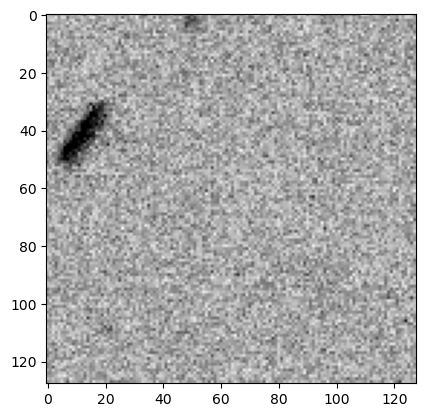

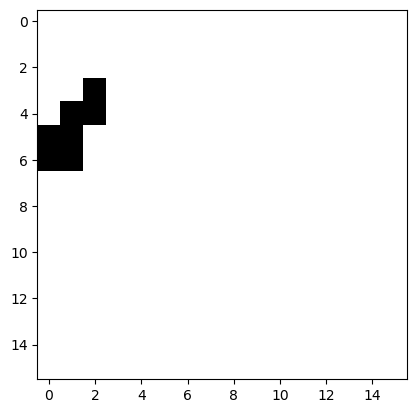

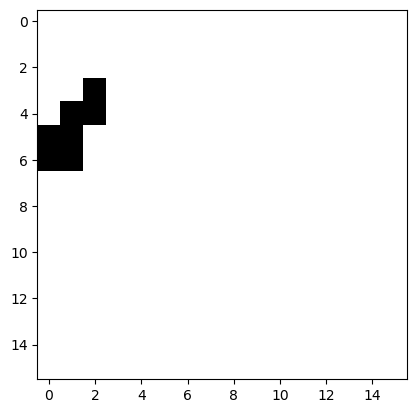

In [29]:
i = np.argwhere(y==1)[2000,0]
plt.imshow(x[i, 0], cmap="Grays")
plt.show()
plt.imshow(p.numpy()[i, 0], cmap="Grays")
plt.show()
plt.imshow(y_d[i, 0], cmap="Grays")

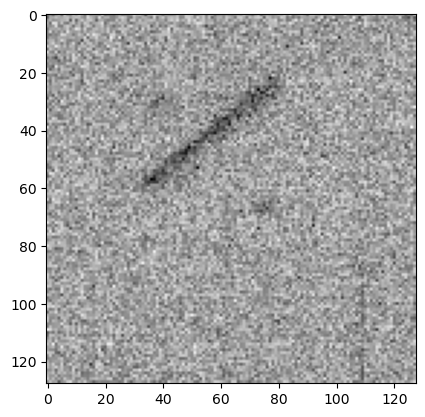

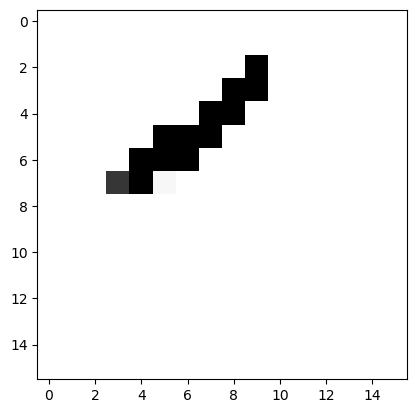

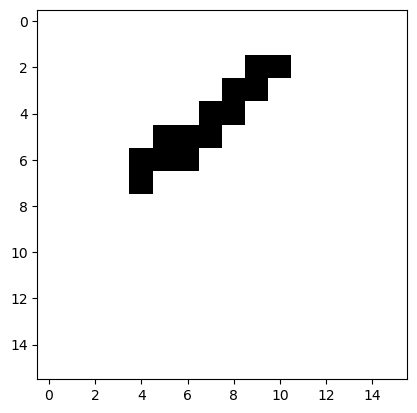

In [30]:
i = np.argwhere(y==1)[5000,0]
plt.imshow(x[i, 0], cmap="Grays")
plt.show()
plt.imshow(p.numpy()[i, 0], cmap="Grays")
plt.show()
plt.imshow(y_d[i, 0], cmap="Grays")